In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sksurv.datasets import load_gbsg2
from sksurv.datasets import get_x_y
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
    brier_score
)

from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer


import PyWGCNA
import biomart

from lifelines import CoxPHFitter

from xgboost import XGBRegressor
import optuna

from tqdm import tqdm

In [2]:
samples = pd.read_csv("data/data_clinical_sample.txt", sep="\t", skiprows=4)
samples = samples[(samples.DISEASE_TYPE == "CLL")]
samples.head()

,PATIENT_ID,SAMPLE_ID,CENTER,ONCOTREE_CODE,DISEASE_TYPE,NORMAL_MEAN_COVERAGE,TUMOR_MEAN_COVERAGE,TUMOR_SAMPLE_PURITY,TUMOR_SAMPLE_PLOIDY,CANCER_TYPE,...,RNA_SEQUENCING,RRBS,ARRAY450K,M-CLL_WES,U-CLL_WES,EC_DISCOVERY,EC_EXTENSION,IGLV3_21_R110,U1_STATUS,TMB_NONSYNONYMOUS
0,P-CRC-0001,CRC-0001,Broad,CLLSLL,CLL,63.0,79.7,0.92,2.00,Mature B-Cell Neoplasms,...,Yes,Yes,No,No,Yes,Yes,No,No,WT,0.866667
1,P-CRC-0002,CRC-0002,Broad,CLLSLL,CLL,70.1,135.5,0.94,2.03,Mature B-Cell Neoplasms,...,Yes,Yes,No,No,Yes,Yes,No,No,WT,0.766667
2,P-CRC-0003,CRC-0003,Broad,CLLSLL,CLL,77.2,141.1,0.83,2.05,Mature B-Cell Neoplasms,...,Yes,Yes,No,No,Yes,Yes,No,No,WT,0.233333
3,P-CRC-0004,CRC-0004,Broad,CLLSLL,CLL,60.2,146.0,0.92,2.00,Mature B-Cell Neoplasms,...,Yes,Yes,No,Yes,No,Yes,No,No,WT,1.000000
4,P-CRC-0005,CRC-0005,Broad,CLLSLL,CLL,106.5,82.1,0.87,2.05,Mature B-Cell Neoplasms,...,Yes,Yes,No,No,Yes,Yes,No,No,WT,0.766667


In [3]:
patients = pd.read_csv("data/data_clinical_patient.txt", sep="\t", skiprows=4)
patients = patients.dropna(subset=["OS_STATUS", "OS_MONTHS"])

patients.head()

,PATIENT_ID,AGE,AGE_SAMPLING,SEX,OS_STATUS,OS_MONTHS,DEATH_DAYS,COHORT,IGHV_MUTATION_STATUS,IGHV_IDENTITY_PERCENTAGE,TREATMENT_STATUS,PRIOR_TREATMENT_CATEGORY,TREATMENT_AFTER_SAMPLING,EXPRESSION_CLUSTER,FFS_STATUS,FFS_MONTHS
0,P-CRC-0001,44.0,46.0,Female,DECEASED,147.19,4477.0,UCSD,unmutated,100.00,Pre-treatment,Untreated,Chemo + Ab,EC-u1,1:Failure,43.17
1,P-CRC-0002,55.0,56.0,Male,DECEASED,154.49,4699.0,UCSD,unmutated,100.00,Pre-treatment,Untreated,Chemo + Ab,EC-u1,1:Failure,66.64
2,P-CRC-0003,63.0,63.0,Female,DECEASED,51.25,1559.0,UCSD,unmutated,100.00,Pre-treatment,Untreated,Chemo + Ab,EC-u2,1:Failure,27.75
3,P-CRC-0004,51.0,51.0,Male,LIVING,183.55,0.0,UCSD,mutated,92.28,Pre-treatment,Untreated,Chemo + Ab,EC-m4,1:Failure,92.48
4,P-CRC-0005,36.0,37.0,Male,LIVING,164.35,0.0,UCSD,unmutated,100.00,Pre-treatment,Untreated,Chemo + Ab,EC-u2,1:Failure,59.57


In [4]:
clin_data = patients.merge(samples.groupby("PATIENT_ID").first().reset_index(), how="inner", on="PATIENT_ID")

In [5]:
clin_data.isna().sum(axis=0)

PATIENT_ID                    0
AGE                          50
AGE_SAMPLING                  0
SEX                           0
OS_STATUS                     0
OS_MONTHS                     0
DEATH_DAYS                    0
COHORT                        0
IGHV_MUTATION_STATUS         15
IGHV_IDENTITY_PERCENTAGE     18
TREATMENT_STATUS              0
PRIOR_TREATMENT_CATEGORY      0
TREATMENT_AFTER_SAMPLING    612
EXPRESSION_CLUSTER            0
FFS_STATUS                    0
FFS_MONTHS                    0
SAMPLE_ID                     0
CENTER                        0
ONCOTREE_CODE                 0
DISEASE_TYPE                  0
NORMAL_MEAN_COVERAGE         83
TUMOR_MEAN_COVERAGE          83
TUMOR_SAMPLE_PURITY          83
TUMOR_SAMPLE_PLOIDY          83
CANCER_TYPE                   0
CANCER_TYPE_DETAILED          0
SOMATIC_STATUS                0
CLL_EPITYPE                   0
TUMOR_MOLECULAR_SUBTYPE     144
SEQUENCING_PLATFORM           0
RNA_SEQUENCING                0
RRBS    

In [6]:
categorical_cols = clin_data.dtypes[clin_data.dtypes == object].index

for catcol in categorical_cols[:]:
    print(clin_data[catcol].value_counts(), "\n")

PATIENT_ID
P-CRC-0001     1
P-CRC-0002     1
P-CRC-0003     1
P-CRC-0004     1
P-CRC-0005     1
              ..
P-SCLL-0502    1
P-SCLL-0503    1
P-SCLL-0504    1
P-SCLL-0505    1
P-SCLL-0506    1
Name: count, Length: 1008, dtype: int64 

SEX
Male      655
Female    353
Name: count, dtype: int64 

OS_STATUS
LIVING      722
DECEASED    286
Name: count, dtype: int64 

COHORT
ICGC      448
GCLLSG    278
DFCI      171
NHLBI      68
MDACC      22
UCSD       21
Name: count, dtype: int64 

IGHV_MUTATION_STATUS
mutated      518
unmutated    475
Name: count, dtype: int64 

TREATMENT_STATUS
Pre-treatment     919
Post-treatment     89
Name: count, dtype: int64 

PRIOR_TREATMENT_CATEGORY
Untreated        919
Chemo + Ab        37
Chemo + no Ab     26
Rel/Ref           22
Ab + no Chemo      3
LEN + Ab           1
Name: count, dtype: int64 

TREATMENT_AFTER_SAMPLING
Chemo + Ab            219
Chemo + no Ab         104
Ab + no chemo          21
BTK inhibitor          17
LEN + chemo + Ab        6
PI3K 

In [7]:
columns_to_drop = ["AGE_SAMPLING", "EXPRESSION_CLUSTER", "FFS_STATUS", "PATIENT_ID", "DEATH_DAYS", "CENTER", "ONCOTREE_CODE", "DISEASE_TYPE", 
                   "CANCER_TYPE", "CANCER_TYPE_DETAILED", "SOMATIC_STATUS", "SEQUENCING_PLATFORM", "RNA_SEQUENCING", "RRBS",
                   "ARRAY450K", "M-CLL_WES", "U-CLL_WES", "EC_DISCOVERY", "EC_EXTENSION", "FFS_MONTHS"]
columns_drop_na = ["AGE", "IGHV_MUTATION_STATUS", "IGHV_IDENTITY_PERCENTAGE", "IGLV3_21_R110"]
columns_to_reduced_onehot = ["SEX", "COHORT", "IGHV_MUTATION_STATUS", "TREATMENT_STATUS", "PRIOR_TREATMENT_CATEGORY", "IGLV3_21_R110", "OS_STATUS"]
columns_to_full_onehot = ["TREATMENT_AFTER_SAMPLING", "CLL_EPITYPE", "TUMOR_MOLECULAR_SUBTYPE", "U1_STATUS"]

In [8]:
clin_data = (clin_data.dropna(subset=columns_drop_na)
            .drop(columns_to_drop, axis=1)) 
clin_data = clin_data[clin_data.CLL_EPITYPE.isin(["n-CLL", "m-CLL", "i-CLL", "0"])]
clin_data["CLL_EPITYPE"] = clin_data["CLL_EPITYPE"].replace({"0": np.nan})
clin_data = clin_data[clin_data["TREATMENT_AFTER_SAMPLING"].isin(["Chemo + Ab", "Chemo + no Ab", "Ab + no chemo", "BTK inhibitor", np.nan])]
clin_data = clin_data[clin_data["PRIOR_TREATMENT_CATEGORY"].isin(["Untreated", "Chemo + Ab", "Chemo + no Ab" , np.nan])]


In [9]:
clin_data = pd.get_dummies(
    clin_data,
    columns=columns_to_reduced_onehot,
    drop_first=True
)

clin_data = pd.get_dummies(
    clin_data,
    columns=columns_to_full_onehot,
    drop_first=False
)

In [10]:
clin_data.loc[:, clin_data.dtypes == bool] = clin_data.loc[:, clin_data.dtypes == bool].astype(int)


In [11]:
clin_data = clin_data.rename({"OS_STATUS_LIVING": "event", "OS_MONTHS": "event_time"}, axis=1)
clin_data["event"] = clin_data["event"].replace({"DECEASED": 1, "LIVING": 0})
clin_data[["event", "event_time"]] = clin_data[["event", "event_time"]].astype(int)

In [12]:
clin_data.to_csv("processed_patients.csv")

# Train-test Split

In [13]:
Cox_train, Cox_test = train_test_split(clin_data.drop("SAMPLE_ID", axis=1), test_size=0.15, random_state=42)
Cox_train, Cox_val = train_test_split(Cox_train, test_size=0.15, random_state=42)
Cox_train.shape, Cox_val.shape, Cox_test.shape

((626, 31), (111, 31), (131, 31))

In [14]:
imputer = KNNImputer(weights="distance", n_neighbors=5)
clin_data_cols = clin_data.drop("SAMPLE_ID", axis=1).columns

Cox_train = pd.DataFrame(imputer.fit_transform(Cox_train), columns=clin_data_cols)
Cox_val = pd.DataFrame(imputer.transform(Cox_val), columns=clin_data_cols)
Cox_test = pd.DataFrame(imputer.transform(Cox_test), columns=clin_data_cols)

# Remove uncorrelated cols

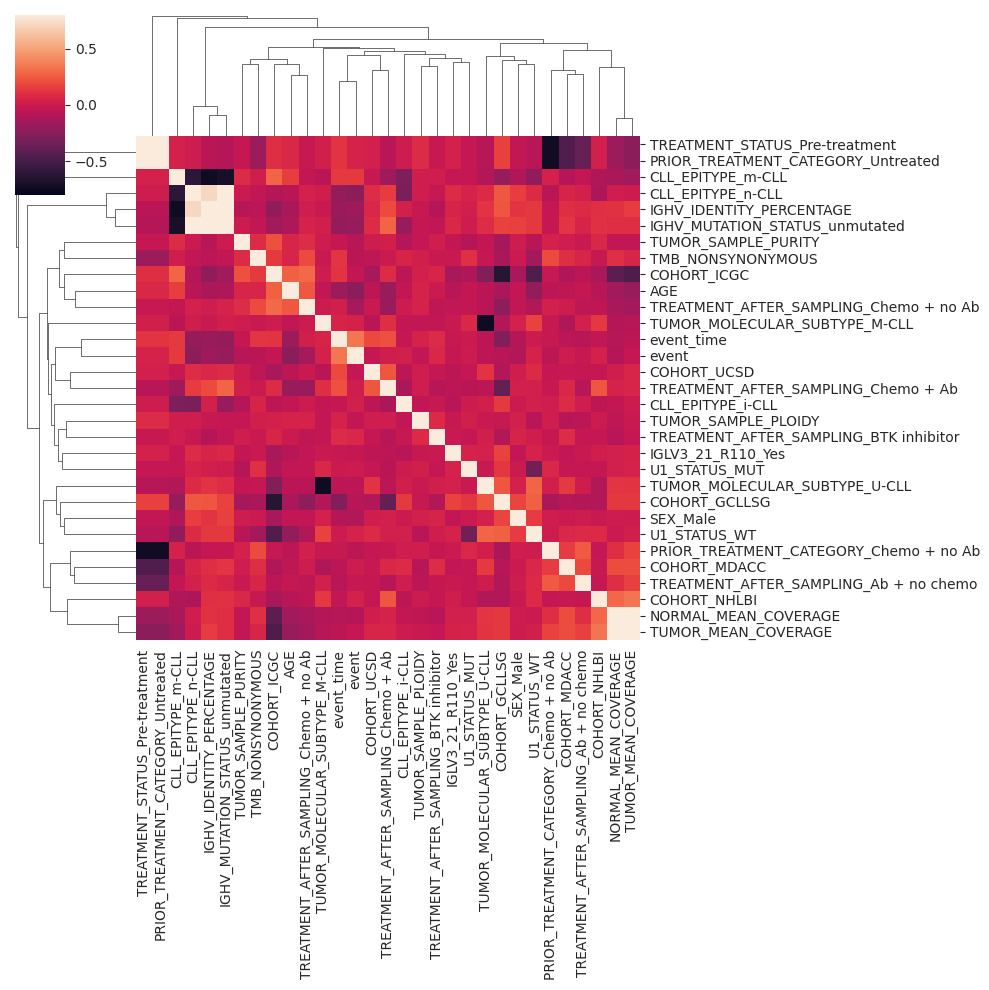

In [15]:
sns.clustermap(pd.DataFrame(Cox_train, columns=clin_data.drop("SAMPLE_ID", axis=1).columns).corr(), vmin=-0.8, vmax=0.8)

In [16]:
columns_to_drop_corr = ['CLL_EPITYPE_i-CLL', 'CLL_EPITYPE_m-CLL', 'CLL_EPITYPE_n-CLL', 'IGHV_MUTATION_STATUS_unmutated', 'TUMOR_MOLECULAR_SUBTYPE_M-CLL', 'COHORT_ICGC',
                        'TREATMENT_STATUS_Pre-treatment', 'PRIOR_TREATMENT_CATEGORY_Chemo + no Ab', 'PRIOR_TREATMENT_CATEGORY_Untreated', 'TUMOR_MEAN_COVERAGE']

In [17]:
Cox_train = Cox_train.drop(columns_to_drop_corr, axis=1)
Cox_val = Cox_val.drop(columns_to_drop_corr, axis=1)
Cox_test = Cox_test.drop(columns_to_drop_corr, axis=1)

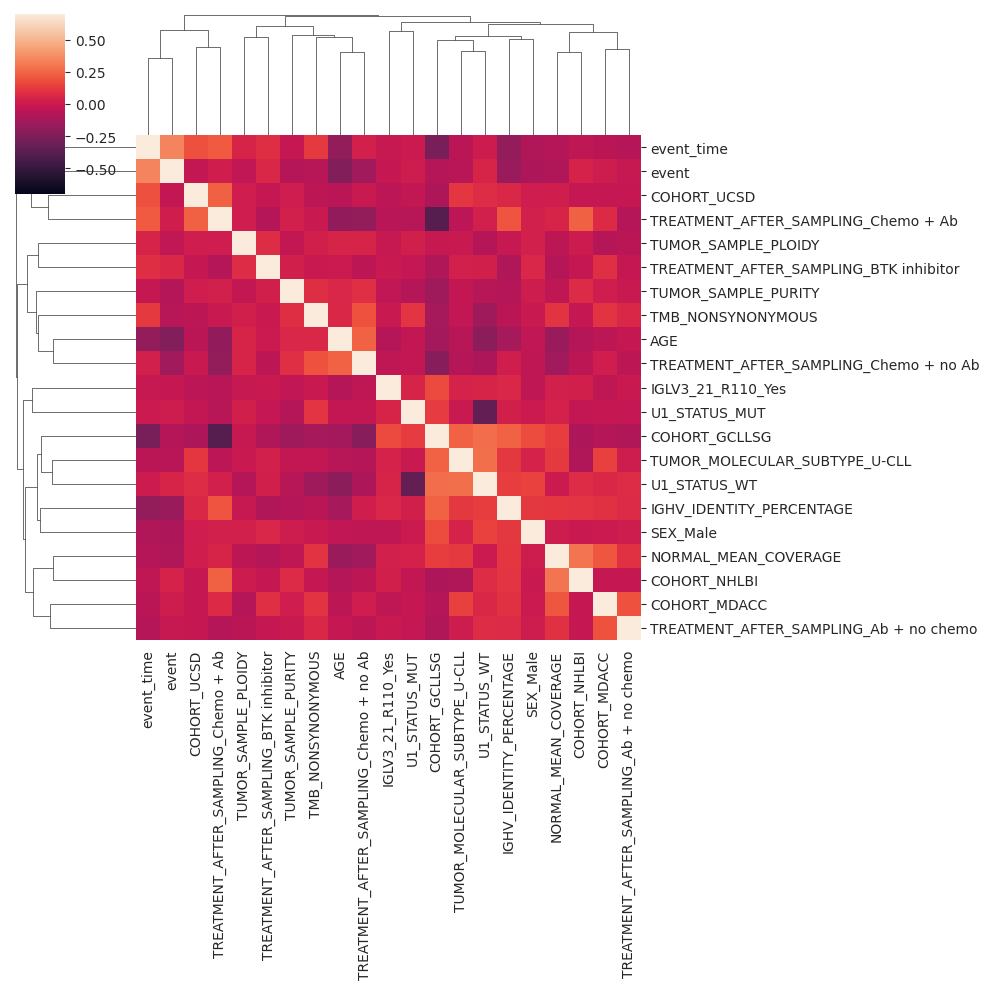

In [18]:
sns.clustermap(Cox_train.corr(), vmin=-0.7, vmax=0.7)

## Cox Regression

In [19]:
cph = CoxPHFitter()
cph.fit(Cox_train, duration_col = "event_time", event_col = "event")

print(cph.score(Cox_train, scoring_method="concordance_index"))
print(cph.score(Cox_val, scoring_method="concordance_index"))
print(cph.score(Cox_test, scoring_method="concordance_index"))

0.6527654440963089
0.6742134666274625
0.6526819923371647


In [308]:
penalizer_values = np.logspace(-3, 1, 100)

val_ci_arr = []

for p in tqdm(penalizer_values):
    cph = CoxPHFitter(penalizer=p)
    cph.fit(Cox_train, duration_col="event_time", event_col="event")

    train_cindex = cph.score(Cox_train, scoring_method="concordance_index")
    val_cindex = cph.score(Cox_val, scoring_method="concordance_index")

    val_ci_arr.append(val_cindex)

100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


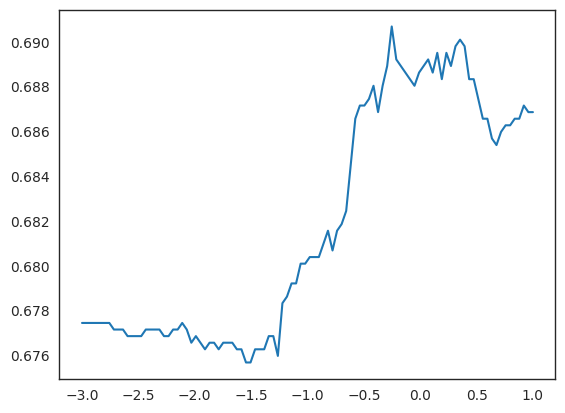

In [309]:
plt.plot(np.log(penalizer_values) / np.log(10), val_ci_arr)

In [310]:
penalizer_values[np.argmax(val_ci_arr)], val_ci_arr[np.argmax(val_ci_arr)]

(np.float64(0.5590810182512228), np.float64(0.6906792119964716))

In [311]:
cph = CoxPHFitter(penalizer=penalizer_values[np.argmax(val_ci_arr)])
cph.fit(Cox_train, duration_col = "event_time", event_col = "event")

print(cph.score(Cox_train, scoring_method="concordance_index"))
print(cph.score(Cox_val, scoring_method="concordance_index"))
print(cph.score(Cox_test, scoring_method="concordance_index"))

0.6478980614245262
0.6906792119964716
0.6498084291187739


In [312]:
cph.summary[cph.summary.p < 0.05].index.tolist()

['TMB_NONSYNONYMOUS',
 'COHORT_GCLLSG',
 'COHORT_UCSD',
 'TREATMENT_AFTER_SAMPLING_Chemo + Ab',
 'TREATMENT_AFTER_SAMPLING_Chemo + no Ab']